In [106]:
import pandas as pd
from pymongo import MongoClient
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.tokenize import TweetTokenizer

import tweepy
import time

from string import punctuation
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json
import seaborn as sns
import matplotlib.pyplot as plt

#from wordcloud import WordCloud, STOPWORDS 

pd.set_option('display.max_colwidth',300)



In [107]:
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        normalized = json_normalize(sanitized)
        df = pd.DataFrame(normalized)

        return df

# Carga dos dados

Conexão e consulta dos dados no mongodb
Carga dos dados no pandas dataframe

In [108]:
host = '172.17.0.3'
port = 27017
collection = 'cemig'
db_name = 'cemig'
collection = 'raw_tweets'

conn = MongoClient(host, port)
db = conn[db_name]
cursor = db[collection].find({},{"_id":0,"id":1,"retweeted":1,"timestamp_ms":1,"text":1,'user.screen_name':1,'user.location':1,'user.followers_count':1,'user.friends_count':1})
df_tweets =  mongo_to_dataframe(cursor)

Carga e parse do arquivo contendo palavras e polaridades
Criação de um dicionário contendo palavra e polaridade

In [109]:
df_arq = pd.read_csv('SentiLex-PT02/SentiLex-flex-PT02.txt', header=None, names=['col'], sep='#')
df_arq = df_arq[~df_arq.col.str.contains("IDIOM")]

df_sentilex = df_arq.col.str.extract(r'^(?P<palavra>.*),.*\.PoS.*=(?P<polaridade>.?[0-9]);ANOT', expand=True)
df_sentilex = pd.Series(df_sentilex.polaridade.values,index=df_sentilex.palavra).to_dict()


In [102]:


APP_KEY="xLOajxwsYIf0vcDEJZDia25Ob"
APP_SECRET="z9K2L8e6BbVV6eUY05apuEWTqqCTse6rCOxWqX2Nb1aA2eeI9d"
OAUTH_TOKEN="30895751-9ZFWSUilQpeNc6trGdShEEErOdDtLfSM8W35rUsZa"
OAUTH_TOKEN_SECRET="gFzdNSa7tDr732PuTaHugkNjh1YKyrMua6Xi9h1ikshq4"

auth = tweepy.OAuthHandler(APP_KEY,APP_SECRET)
auth.set_access_token(OAUTH_TOKEN,OAUTH_TOKEN_SECRET)

api = tweepy.API(auth)
'''for status in api.user_timeline(screen_name='acmigdtuw',include_rts=1,count=200):
    print status.id'''

#firstTweet = api.user_timeline(screen_name="acmigdtuw")[0]
#print firstTweet.text
#print firstTweet.id
#results = api.retweets(status.id,cursor=-1,stringify_ids=1) 
pl = api.retweets(1109215677053837313) 
print(pl)

[Status(_api=<tweepy.api.API object at 0x7f02bab121d0>, _json={'created_at': 'Sat Mar 23 13:49:00 +0000 2019', 'id': 1109451986758443008, 'id_str': '1109451986758443008', 'text': 'RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\nhttps://t.co/QjdpF…', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'jornalhojeemdia', 'name': 'Jornal Hoje em Dia', 'id': 38498888, 'id_str': '38498888', 'indices': [3, 19]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 82692712, 'id_str': '82692712', 'name': 'Eriênio Souza', 'screen_name': 'EriMatematico', 'location': 'Brasil - BH - MG', 'description': 'Mineiro, Engenheiro Civil (carregando...) Mat

In [110]:
df_tweets["tempo"] = pd.to_datetime(df_tweets['timestamp_ms'], unit='ms').dt.tz_localize('America/Sao_Paulo')
df_tweets["data"] = df_tweets["tempo"].dt.date
df_tweets["text"] = df_tweets["text"].str.replace('https:\/\/.*\s?','')

df_tweets.head()


,id,retweeted,text,timestamp_ms,user.followers_count,user.friends_count,user.location,user.screen_name,tempo,data
0,1107042314097229824,False,"CEMIG ta vacilona hoje em, assim não dá",1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16 22:13:50.189000-03:00,2019-03-16
1,1107052443580420096,False,Ficar sem luz e foda essa loja da Cemig,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16 22:54:05.246000-03:00,2019-03-16
2,1107053694523228160,False,Cemig zuando os pratence hihihi,1552777143494,382,295,ciúmentolandia,sou_geise,2019-03-16 22:59:03.494000-03:00,2019-03-16
3,1107072220281688064,False,@BETHEVITAS @mxrcone CEMIG curtiu isso.,1552781560379,1461,1466,"Minas Gerais, Brasil",jkbrunno,2019-03-17 00:12:40.379000-03:00,2019-03-17
4,1107098836516962305,False,Recado dos Eletricitários em defesa da CEMIG - FNU,1552787906184,63,1697,Rio de Janeiro - Brasil,magu5,2019-03-17 01:58:26.184000-03:00,2019-03-17


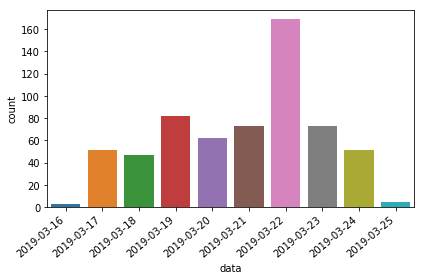

In [111]:
ax = sns.countplot(x="data", data=df_tweets)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [112]:
df_tokens = pd.DataFrame()

for index, row in df_tweets.iterrows():
    palavras = word_tokenize(row['text'].lower())
    sw = set(stopwords.words('portuguese') + list(punctuation) + list(['cemig','…','¿','...','-…','https','rt','pra','r','é','tá']))
    
    df_token_tmp = pd.DataFrame()
    df_token_tmp["tokens"] = [palavra for palavra in palavras if palavra not in sw]
    df_token_tmp["id"] = row['id']
    df_token_tmp["polaridade"] = df_token_tmp["tokens"].apply(df_sentilex.get)
    
    #print(df_token_tmp)
    df_tokens = df_tokens.append(df_token_tmp, ignore_index=True)
#    df_token_tmp["tokens"] = 
#    df_tokens["id"] = row['id']
        
df_tweets_tokens = df_tokens.set_index('id').join(df_tweets.set_index('id'))


In [113]:
df_tweets_tokens.groupby('tokens').tokens.count().nlargest(10)

tokens
energia          61
luz              60
cmig4            54
cmig-n1          49
mil              39
renova           37
camarote         36
romeuzema        33
anos             32
independência    31
Name: tokens, dtype: int64

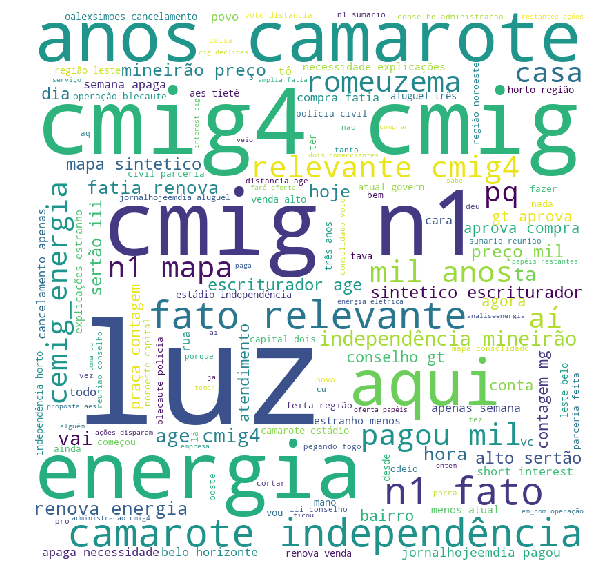

In [115]:
texto_cloud = ' '.join(df_tweets_tokens.tokens)

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(texto_cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [116]:
df_cmig4 = df_tweets_tokens[['text','data']].loc[df_tweets_tokens['tokens'] == 'cmig4']
df_cmig4.head(5)

,text,data
id,,
1108315694775492609,Cemig para Abril de 2019 😍 - gráfico de #CMIG4,2019-03-20
1108317267865952256,#CMIG4 - Cemig para Abril de 2019 😍 - TradingView -,2019-03-20
1108936597116903424,$CMIG4 $RNEW11 \n\nCelebração de Contrato para Aquisição de Participação na Renova Energia S.A.\n(“Renova”) e Realizaç…,2019-03-22
1109062517735731200,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22
1109062519933554688,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22


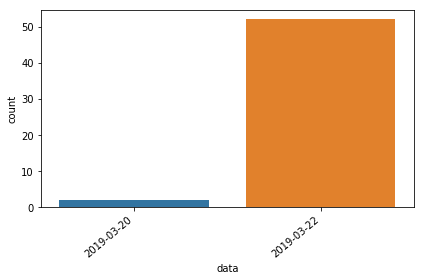

In [56]:
ax = sns.countplot(x="data", data=df_cmig4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [57]:
df_camarote = df_tweets_tokens[['text','user.screen_name','data']].loc[df_tweets_tokens['tokens'] == 'camarote']
df_camarote.head(5) 

,text,user.screen_name,data
id,,,
1109215677053837313,"Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\nhttps://t.co/QjdpFL4TF3",jornalhojeemdia,2019-03-22
1109215897464512515,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\nhttps://t.co/QjdpF…",REGINALDOGALO10,2019-03-22
1109216983755698176,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\nhttps://t.co/QjdpF…",digaormf,2019-03-22
1109217168451883009,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\nhttps://t.co/QjdpF…",rafael_fr2,2019-03-22
1109218880659079170,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\nhttps://t.co/QjdpF…",sracansada,2019-03-22


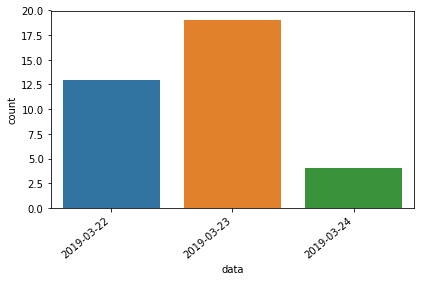

In [58]:
ax = sns.countplot(x="data", data=df_camarote)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [59]:
df_tweets_tokens_neg = df_tweets_tokens.loc[df_tweets_tokens['polaridade'] == '-1']
df_tweets_tokens_neg.groupby('tokens').tokens.count().nlargest(10)

tokens
venda       23
apaga       14
odeio       12
estranho    10
pisca        6
apagava      5
caiu         5
derrotas     5
falta        5
vender       5
Name: tokens, dtype: int64

In [61]:
df_venda = df_tweets_tokens_neg[['text','data']].loc[df_tweets_tokens_neg['tokens'] == 'venda']
df_venda.head(5)

,text,data
id,,
1107123548622123008,"@joaoamoedonovo até agora nada do ""novo"" ter anunciado a venda das 2 estatais CEMIG E COPASA, que estão oprimindo o povo",2019-03-17
1107656184926998528,"Vejam o péssimo atendimento da Cemig, 20 minutos para pegar uma senha de atendimento, na Agência de Venda Nova!… https://t.co/6vovHDYfhG",2019-03-18
1107657455771758592,"RT @renato_artur: Vejam o péssimo atendimento da Cemig, 20 minutos para pegar uma senha de atendimento, na Agência de Venda Nova!#CEMIG htt…",2019-03-18
1109060826328166400,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III - https://t.co/RXJF6pPJnX,2019-03-22
1109061194986459136,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III - https://t.co/wd7qKr63Ls,2019-03-22


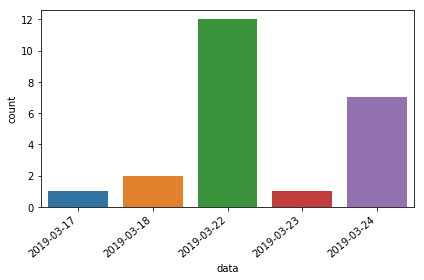

In [62]:
ax = sns.countplot(x="data", data=df_venda)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [67]:
df_apaga = df_tweets_tokens_neg[['text','data']].loc[df_tweets_tokens_neg['tokens'] == 'apaga']
df_apaga.head(5)

,text,data
id,,
1107133154068971521,@BellaMoreira8 e a minha que tá o dia todo “apaga a luz e deixa o tempo passar BABY VOCÊ NÃO PERDE POR ESPERAR APAG… https://t.co/hgpPs1yCc8,2019-03-17
1107417138879438849,"Cemig, se for pra piscar a luz de 10 em 10s apaga essa porra logo caralho\n\nPelo menos não queima o resto do meu PC",2019-03-17
1107828522687565824,Luz Aq de casa tá acende apaga acende apaga. Decide logo se vai ter apagão ou não cemig,2019-03-19
1107828522687565824,Luz Aq de casa tá acende apaga acende apaga. Decide logo se vai ter apagão ou não cemig,2019-03-19
1109210554269384705,"O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual… https://t.co/HAdoWxfOIw",2019-03-22


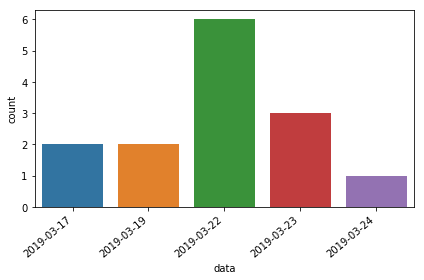

In [68]:
ax = sns.countplot(x="data", data=df_apaga)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [69]:
df_estranho = df_tweets_tokens_neg[['text','data']].loc[df_tweets_tokens_neg['tokens'] == 'estranho']
df_estranho.head(5)

,text,data
id,,
1109210554269384705,"O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual… https://t.co/HAdoWxfOIw",2019-03-22
1109210645096996867,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22
1109211591860514816,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22
1109212636061810688,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22
1109215638982180865,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22


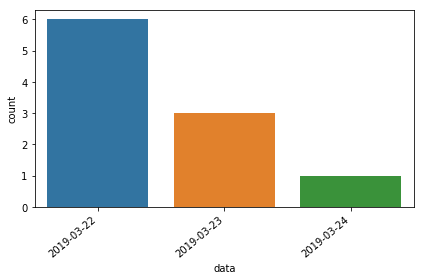

In [70]:
ax = sns.countplot(x="data", data=df_estranho)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [233]:
df_tweets_tokens_pos = df_tweets_tokens.loc[df_tweets_tokens['polaridade'] == '1']
df_tweets_tokens_pos.groupby('tokens').tokens.count().nlargest(10)

tokens
energia       63
relevante     21
apaga         14
belo          10
bem            8
apagava        5
derrotas       5
boa            3
certíssimo     3
eficiente      3
Name: tokens, dtype: int64

In [257]:
df_energia = df_tweets_tokens_pos[['text','data']].loc[df_tweets_tokens_pos['tokens'] == 'energia']

df_energia.head(5)

,text,data
id,,
1107125367767207936,"CEMIG Serviços S.A., vocês conseguiriam me recomendar alguma empresa de fornecimento de energia elétrica? A empresa… https://t.co/9S074ohcAx",2019-03-17
1107138321044647938,ta faltando energia aqui Cemig \nbunita,2019-03-17
1107145095013433344,"caiu a energia e vou dormir no valor, valeu Cemig.",2019-03-17
1107338090975236097,que maravilha ein cemig sem estar chovendo to sem energia,2019-03-17
1107380419018797064,"Eu tô pensando é como vamos trabalhar na segunda pós sunsetville, mas tudo bem \nCemig vai ter que me dar energia 😂",2019-03-17


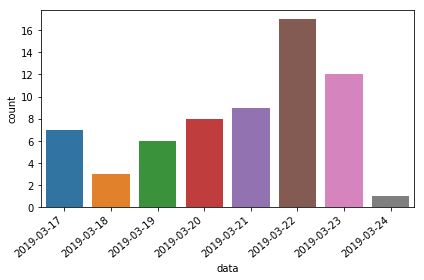

In [258]:
ax = sns.countplot(x="data", data=df_energia)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [253]:
df_tweets_tokens_pos[['text','data']].loc[df_tweets_tokens_pos['tokens'] == 'belo']

,text,data
id,,
1108715417101656064,"Impressionante... Belo Horizonte parada por causa da Cemig, em pleno horário comercial, sem aviso prévio... em IMPL… https://t.co/wKDfOgCt6j",2019-03-21
1109486683190423553,"Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte,… https://t.co/zpJr2TnDGt",2019-03-23
1109487464819974146,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23
1109494136988729344,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23
1109500064228167681,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23
1109523123387420673,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23
1109531083744464896,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23
1109578267252666369,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23
1109579474125930497,"RT @jornalhojeemdia: Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte, a C…",2019-03-23


In [254]:
df_tweets_tokens_pos[['text','data']].loc[df_tweets_tokens_pos['tokens'] == 'relevante']

,text,data
id,,
1109062517735731200,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/Dmem0VQzPH,2019-03-22
1109062519933554688,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/e9lfnsZKRK,2019-03-22
1109062601764495361,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/obDg5nb5IZ,2019-03-22
1109062604159356928,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/90XArq3MG1,2019-03-22
1109062646630887427,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/oKuGXbPsg7,2019-03-22
1109062648824360960,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/iZ4s4HSdoF,2019-03-22
1109062651659935745,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/BR7PbsRrD1,2019-03-22
1109062654700720128,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/ZFMdkWKlQQ,2019-03-22
1109062664175652865,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19 https://t.co/DnSw6ViTl7,2019-03-22


In [255]:
df_tweets_tokens_pos[['text','data']].loc[df_tweets_tokens_pos['tokens'] == 'energia']

,text,data
id,,
1107125367767207936,"CEMIG Serviços S.A., vocês conseguiriam me recomendar alguma empresa de fornecimento de energia elétrica? A empresa… https://t.co/9S074ohcAx",2019-03-17
1107138321044647938,ta faltando energia aqui Cemig \nbunita,2019-03-17
1107145095013433344,"caiu a energia e vou dormir no valor, valeu Cemig.",2019-03-17
1107338090975236097,que maravilha ein cemig sem estar chovendo to sem energia,2019-03-17
1107380419018797064,"Eu tô pensando é como vamos trabalhar na segunda pós sunsetville, mas tudo bem \nCemig vai ter que me dar energia 😂",2019-03-17
1107417158668247040,Cemig eu te odeio pq se faltar energia vou surtar nem jantei ainda odeio comer no escuro,2019-03-17
1107420107767275520,RT @helena__carvlho: Cemig eu te odeio pq se faltar energia vou surtar nem jantei ainda odeio comer no escuro,2019-03-17
1107482804529565701,Caralho o motivo de ter acabado a energia é q pego fogo no negócio da Cemig slc bicho q medo desses troço,2019-03-18
1107599066307969025,"@cemig_energia RT @cemig_energia #Efficientia: A #empresa de #serviços de #energia da #Cemig, vai investir até R$ 5… https://t.co/vP5KNWdaw3",2019-03-18


In [75]:

#b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
#b.columns = ['var1', 'var2'] # renaming var1







palavras = word_tokenize(texto.lower())
    
sw = set(stopwords.words('portuguese') + list(punctuation))
palavras = [palavra for palavra in palavras if palavra not in sw]
    
    #Stemmer
    #palavras_t2 = [stemmer.stem(palavra) for palavra in palavras_t1]
    
    #print(palavras_t2)
    
    nota = 0
    for palavra in palavras:
    
        pol = dict_sentilex.get(palavra)
    
        if pol is None:
            nota = 0
        else:
            nota  = int(pol)

    return nota

SyntaxError: invalid syntax (<ipython-input-75-2550696be37b>, line 1)

In [35]:
df_tweets.head()

,id,text,timestamp_ms,user.followers_count,user.friends_count,user.location,user.screen_name
0,1107042314097229824,"CEMIG ta vacilona hoje em, assim não dá",1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra
1,1107042314097229824,"CEMIG ta vacilona hoje em, assim não dá",1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra
2,1107052443580420096,Ficar sem luz e foda essa loja da Cemig,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21
3,1107053694523228160,Cemig zuando os pratence hihihi,1552777143494,382,295,ciúmentolandia,sou_geise
4,1107072220281688064,@BETHEVITAS @mxrcone CEMIG curtiu isso.,1552781560379,1461,1466,"Minas Gerais, Brasil",jkbrunno


In [42]:
bag_words = pd.Series([y.lower() for x in df_tweets.text.values.flatten() for y in x.split()])



bag_words = bag_words.str.replace(r'[\!\?\.\,\_\;\…\(\)]+','')
sw = set(stopwords.words('portuguese'))

bag_words = pd.Series([x for x in bag_words if x not in sw])

df_bag = pd.DataFrame(bag_words.value_counts(), columns=['freq']).rename_axis('palavra').reset_index()
df_bag['polaridade'] = pd.Series([dict_sentilex.get(x) for x in df_bag.palavra.values])

df_bag['polaridade'] = df_bag['polaridade'].fillna(0)
df_bag['polaridade'] = pd.to_numeric(df_bag['polaridade'])

df_bag.groupby('polaridade').polaridade.count()
df_bag.loc[df_bag['polaridade'] == -1]

bag_words.value_counts()
#df_bag_words = pd.Series([palavra for palavra in palavras if palavra not in sw])


cemig                     489
-                         195
rt                        104
energia                    62
luz                        60
pra                        54
é                          51
$cmig4                     50
cmig-n1                    49
r$                         44
mil                        41
camarote                   36
tá                         35
@romeuzema                 34
renova                     33
                           33
anos                       32
independência              32
21/03/19                   28
3                          26
vai                        26
aqui                       24
venda                      23
fato                       22
pagou                      21
990                        21
mapa                       21
mineirão                   21
25/03/19                   21
age                        21
                         ... 
y                           1
ene                         1
@traderscl

In [ ]:
from nltk.probability import FreqDist

frequencia = FreqDist(palavras_sem_stopwords)

from collections import defaultdict

sentencas_importantes = defaultdict(int)

for i, sentenca in enumerate(sentencas):
    for palavra in word_tokenize(sentenca.lower()):
        if palavra in frequencia:
            sentencas_importantes[i] += frequencia[palavra]

from heapq import nlargest

idx_sentencas_importantes = nlargest(4, sentencas_importantes, sentencas_importantes.get)

for i in sorted(idx_sentencas_importantes):
    print(sentencas[i])

In [30]:
#df_tweets['sentimento'] = df_tweets['text'].apply(get_sentimento)

#df_tweets.loc[df_tweets['sentimento'] == 1].text

#df_tweets.groupby('sentimento').sentimento.count()

#rectangles_df['area'] = rectangles_df.apply(calculate_area, axis=1)
#df_tweets.head()

NameError: name 'word_tokenize' is not defined

In [325]:
df_tweets.groupby('sentimento').sentimento.count()

#sentimento
#-3      2
#-2     10
#-1     52
# 0    389
# 1     99
# 2      3
#Name: sentimento, dtype: int64


#sentimento
#-1    123
# 0    432
#Name: sentimento, dtype: int64

#sentimento
#-1    179
# 0    376
#Name: sentimento, dtype: int64

sentimento
-1    346
 0    211
Name: sentimento, dtype: int64